In [ ]:
# Purpose is to confirm original 2Dconv model working,
    # prep for dense layer swap v02
# read 4 square files
    # trn/tst n24 pretrain cohorts
    # trn/tst BRCA
# write decoded sample files, to UMAP

In [1]:
%whos

Interactive namespace is empty.


In [3]:
import numpy as np

In [ ]:
# Get original data
# Run direct on float.64, unwrapped data after layer swap

In [11]:
ls ../../image_gen/a_data_structure/

a_data_structure_00.ipynb  n24_trn_y_5260.tsv
archive/                   n24_tst_X_1754.npy
med_abs_dev.ipynb          n24_tst_y_1754.tsv
n24_trn_X_5260.npy


In [5]:
X_train_new = np.load('../../image_gen/a_data_structure/n24_trn_X_5260.npy')

In [6]:
X_test_new = np.load('../../image_gen/a_data_structure/n24_tst_X_1754.npy')

In [7]:
import tensorflow as tf # kernel check, want all models running on latest
# see venv_setup_J_Lab.txt

2022-10-04 15:23:05.582022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
tf.__version__ # good

'2.10.0'

In [10]:
# Build an image VAE with Keras
# Uses X_train_new object in memory to set layer dimensions
# from https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d

latent_dim = 4

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy

print('libraries done')

np.random.seed(25)
tf.executing_eagerly()

def compute_latent(x):
    batch = K.shape(mu)[0] # mu and sigma defined after encoder is built
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma) # mu and sigma input to loss function
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

img_height   = X_train_new.shape[1]
img_width    = X_train_new.shape[2]
num_channels = X_train_new.shape[3]
input_shape =  (img_height, img_width, num_channels)

encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input) # Overwrite (?)
encoder = Flatten()(encoder_conv)                                 # see model.summary() in slides

mu = Dense(latent_dim)(encoder)     # mu defined
sigma = Dense(latent_dim)(encoder)  # sigma defined
                                                                # 2 args to compute lambda
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
                    
conv_shape = K.int_shape(encoder_conv)
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)  # blank model set for (pre)training
print('model built')

libraries done


In [11]:
epochs = 32

In [13]:
cohort = 'n24'

In [12]:
version = 'b_model_01.ipynb'

In [14]:
date = '2022-10-04'

Train on 5260 samples, validate on 1754 samples
Epoch 1/32


2022-10-04 15:28:39.336132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 15:28:39.372279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


5260/5260 [==============================] - ETA: 0s - loss: 4482.6841

/Users/karlberb/Desktop/RNB00978/sample_count/tf_venv_a/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5260/5260 [==============================] - 26s 5ms/sample - loss: 4482.6841 - val_loss: 3539.8872
Epoch 2/32
5260/5260 [==============================] - 26s 5ms/sample - loss: 3506.6237 - val_loss: 3484.0554
Epoch 3/32
5260/5260 [==============================] - 53s 10ms/sample - loss: 3472.7237 - val_loss: 3463.1314
Epoch 4/32
5260/5260 [==============================] - 25s 5ms/sample - loss: 3457.4757 - val_loss: 3451.9322
Epoch 5/32
5260/5260 [==============================] - 24s 5ms/sample - loss: 3448.3016 - val_loss: 3446.0223
Epoch 6/32
5260/5260 [==============================] - 26s 5ms/sample - loss: 3442.9416 - val_loss: 3440.1261
Epoch 7/32
5260/5260 [==============================] - 27s 5ms/sample - loss: 3438.4895 - val_loss: 3436.4765
Epoch 8/32
5260/5260 [==============================] - 27s 5ms/sample - loss: 3435.0050 - val_loss: 3432.9047
Epoch 9/32
5260/5260 [==============================] - 27s 5ms/sample - loss: 3431.4249 - val_loss: 3429.8883
Epoch 10/32

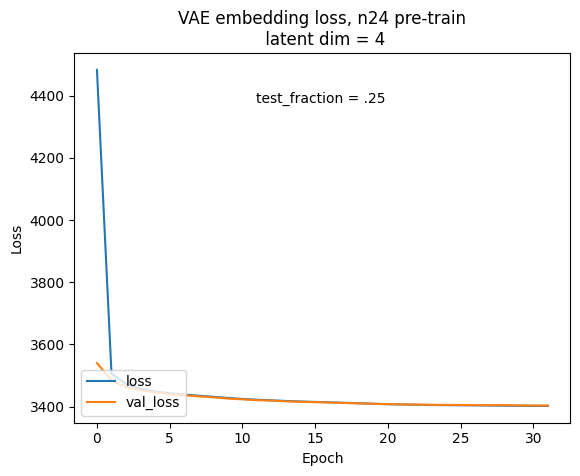

In [15]:
# VAE fitting function (compile check)
history = vae.fit(x=X_train_new, y=X_train_new, epochs=epochs,
                  batch_size=32, # why is this set to 32?
                  validation_data=(X_test_new, X_test_new))

plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.title('VAE embedding loss, '+cohort+' pre-train\n'+
          
          # file.index.name+', burn-in, n = 495'+
          
          ' latent dim = '+str(latent_dim))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('test_fraction = .25',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            # fontsize=20
            )

plt.legend(loc="lower left")
# plt.savefig('dir_n/cohort_n'+str(epochs)+'_epochs_2022-08-date_version.png')
plt.savefig(cohort+'_pretrain_'+
            
            # file.index.name+
            # '_brn_n_'+str(len(brca_burn_in))+'_'+
            
            str(epochs)+'_epochs_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'_r0.png')

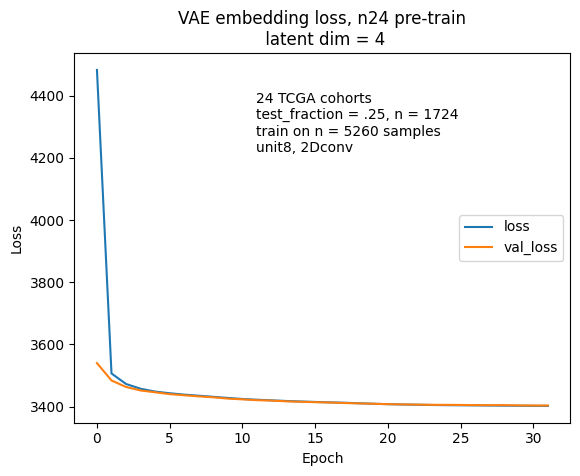

In [18]:
# Fix the plot annotation
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.title('VAE embedding loss, '+cohort+' pre-train\n'+
          
          # file.index.name+', burn-in, n = 495'+
          
          ' latent dim = '+str(latent_dim))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('24 TCGA cohorts\ntest_fraction = .25, n = 1724\ntrain on n = 5260 samples'+
             '\nunit8, 2Dconv',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            # fontsize=20
            )

plt.legend(loc="center right")
# plt.savefig('dir_n/cohort_n'+str(epochs)+'_epochs_2022-08-date_version.png')
plt.savefig(cohort+'_pretrain_'+
            
            # file.index.name+
            # '_brn_n_'+str(len(brca_burn_in))+'_'+
            
            str(epochs)+'_epochs_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'_r0_p1.png')